Lab - EDA Bivariate Analysis: Diving into Amazon UK Product Insights Part II
Objective: Delve into the dynamics of product pricing on Amazon UK to uncover insights that can inform business strategies and decision-making.

Dataset: This lab utilizes the Amazon UK product dataset which provides information on product categories, brands, prices, ratings, and more from Amazon UK. You'll need to download it to start working with it.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

In [2]:
# Loading the housing price dataset (assuming the file name is "housing_price.csv")
df = pd.read_csv("C:/Users/user/Jupyter/IronHack/Work - Python/Week5/Day2/amz_uk_price_prediction_dataset.csv")

In [3]:
# Filtering out columns in the dataframe where more than 80% of the values are missing
df = df[df.columns[df.isnull().mean() < 0.8]]

In [126]:
# Removing the "Id" column from the dataframe
df.drop("uid", inplace=True, axis=1)

In [127]:
df.columns

Index(['asin', 'title', 'stars', 'reviews', 'price', 'isBestSeller',
       'boughtInLastMonth', 'category'],
      dtype='object')

In [128]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2443651 entries, 0 to 2443650
Data columns (total 8 columns):
 #   Column             Dtype  
---  ------             -----  
 0   asin               object 
 1   title              object 
 2   stars              float64
 3   reviews            int64  
 4   price              float64
 5   isBestSeller       bool   
 6   boughtInLastMonth  int64  
 7   category           object 
dtypes: bool(1), float64(2), int64(2), object(3)
memory usage: 132.8+ MB


In [129]:
df.head()

,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers
2,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
3,B09B8T5VGV,"Echo Dot with clock (5th generation, 2022 rele...",4.7,7205,31.99,False,0,Hi-Fi Speakers
4,B09WX6QD65,Introducing Echo Pop | Full sound compact Wi-F...,4.6,1881,17.99,False,0,Hi-Fi Speakers


Part 1: Analyzing Best-Seller Trends Across Product Categories
Objective: Understand the relationship between product categories and their best-seller status.

1. Crosstab Analysis:

Create a crosstab between the product category and the isBestSeller status.




In [130]:
# Generating a crosstab for 'isBestSeller' and 'category'
crosstab = pd.crosstab(df['category'], df['isBestSeller'])

crosstab

isBestSeller,False,True
category,,
3D Printers,247,1
3D Printing & Scanning,4065,2
Abrasive & Finishing Products,245,5
Action Cameras,1696,1
Adapters,251,3
...,...,...
Wind Instruments,243,7
Window Treatments,234,5
Women,17559,213


In [131]:
crosstab.columns

Index([False, True], dtype='bool', name='isBestSeller')

In [132]:
crosstab['Proportion of Best-Sellers'] = crosstab[True] / crosstab.sum(axis=1)
# Sort categories based on proportion of best-sellers
sorted_categories = crosstab.sort_values(by='Proportion of Best-Sellers', ascending=False)
sorted_categories


isBestSeller,False,True,Proportion of Best-Sellers
category,,,
Grocery,9008,556,0.058135
Smart Home Security & Lighting,98,6,0.057692
Health & Personal Care,9017,552,0.057686
Mobile Phone Accessories,248,11,0.042471
Power & Hand Tools,8353,306,0.035339
...,...,...,...
"CD, Disc & Tape Players",8798,0,0.000000
General Music-Making Accessories,259,0,0.000000
Snowboard Boots,1449,0,0.000000


Are there categories where being a best-seller is more prevalent?

Hint: one option is to calculate the proportion of best-sellers for each category and then sort the categories based on this proportion in descending order.

Yes, I've found some categories where being a bet-seller is more prevalent than the others like in Grocery or Health and Personal Care categories

2. Statistical Tests:

Conduct a Chi-square test to determine if the best-seller distribution is independent of the product category.
Compute Cramér's V to understand the strength of association between best-seller status and category.
Visualizations:

In [133]:
from scipy.stats import chi2_contingency

new_crosstab = pd.crosstab(df['category'], df['isBestSeller'])
# Chi-square test for 'isBestSeller' and 'category'
chi2_statistic, chi2_p_value, _, _ = chi2_contingency(new_crosstab)

chi2_statistic, chi2_p_value

(36540.20270061387, 0.0)

The null hypothesis of the Chi-square test is that the two categorical variables are independent. Given the extremely low \( p \)-value, we reject the null hypothesis. This implies that there's a significant association between `isBestSeller` and `category` in the dataset.

3. Visualize the relationship between product categories and the best-seller status using a stacked bar chart.

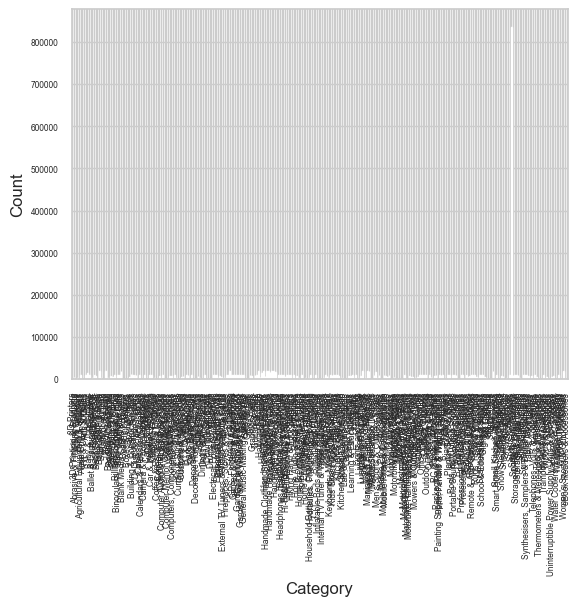

In [134]:
# Plotting a stacked bar chart for the 'crosstab' data
sns.set(style='whitegrid')
ax = new_crosstab.plot(kind='bar', stacked=True, legend=False,fontsize=6)
ax.set_ylabel('Count')
ax.set_xlabel('Category')
plt.show()

Part 2: Exploring Product Prices and Ratings Across Categories and Brands
Objective: Investigate how different product categories influence product prices.

Preliminary Step: Remove outliers in product prices.

For this purpose, we can use the IQR (Interquartile Range) method. Products priced below the first quartile minus 1.5 times the IQR or above the third quartile plus 1.5 times the IQR will be considered outliers and removed from the dataset. The next steps will be done with the dataframe without outliers.

Hint: you can check the last Check For Understanding at the end of the lesson EDA Bivariate Analysis for a hint on how to do this.

In [135]:
# Calculate Q1 and Q3
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)

# Calculate IQR
IQR = Q3 - Q1

# Define lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers
df_no_outliers = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]

1. Violin Plots:

Use a violin plot to visualize the distribution of price across different product categories. Filter out the top 20 categories based on count for better visualization.
Which product category tends to have the highest median price? Don't filter here by top categories.

In [136]:
df_no_outliers.columns

Index(['asin', 'title', 'stars', 'reviews', 'price', 'isBestSeller',
       'boughtInLastMonth', 'category'],
      dtype='object')

In [137]:
# filter out top 20 categories to work with
category_counts_sorted = df_no_outliers['category'].value_counts().sort_values(ascending=False).head(20)
list_categories_top_20 = category_counts_sorted.index.tolist()
# Filter out the list of values from the column
filtered_df = df[df['category'].isin(list_categories_top_20)]
filtered_df

,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
19513,B09477KHQ3,"Personalised Birthday Print Gift ""THE YEAR YOU...",4.5,763,7.99,False,900,Handmade Home & Kitchen Products
19514,B0BSRFQYG8,Wax Melts 4 Bars | Build Your Own Box (Choose ...,3.9,117,6.49,True,800,Handmade Home & Kitchen Products
19515,B09N9GVHV9,"Personalised Birthday Print Gift ""ON THE DAY/Y...",4.6,1155,8.99,True,600,Handmade Home & Kitchen Products
19516,B0BRYGV7PQ,Fresh Wax Melts - Laundry Type Wax Melts - Str...,4.5,56,4.99,True,500,Handmade Home & Kitchen Products
19517,B0B1JHB28R,Manta Makes Work Leaving Gifts | I Used to Wor...,4.7,261,9.95,True,400,Handmade Home & Kitchen Products
...,...,...,...,...,...,...,...,...
2429088,B0045I6SHW,Cannondale Men's Bibshort Dart Team Bike Shorts,0.0,0,99.67,False,0,Sports & Outdoors
2429089,B0045I6NZY,Cannondale Men's Baggy Fitness Bike Shorts,0.0,0,20.62,False,0,Sports & Outdoors
2429090,B003BLON3A,Pearl iZUMi Men's Phase Splice Knicker,4.3,3,59.86,False,0,Sports & Outdoors
2437153,B091HG57TP,Goodstoworld Boys Girls Tracksuit Bottoms 3D S...,4.2,554,14.99,False,0,Sports & Outdoors


<Axes: xlabel='category', ylabel='price'>

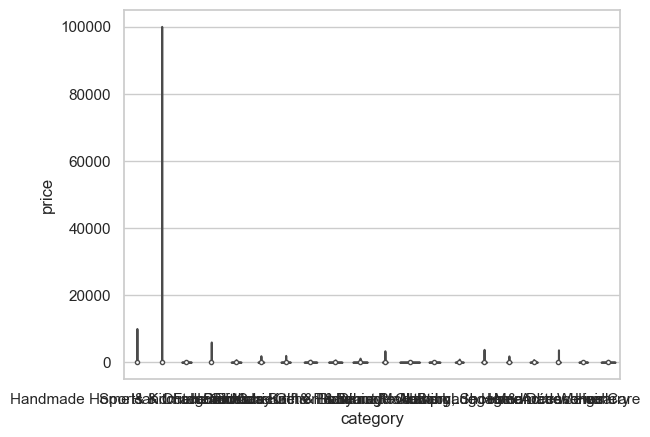

In [138]:
# Violin plot for price without the outliner
sns.violinplot(data=filtered_df, x='category', y='price', palette="coolwarm", fontsize=6)

2. Bar Charts:

Create a bar chart comparing the average price of products for the top 10 product categories (based on count).
Which product category commands the highest average price? Don't filter here by top categories.

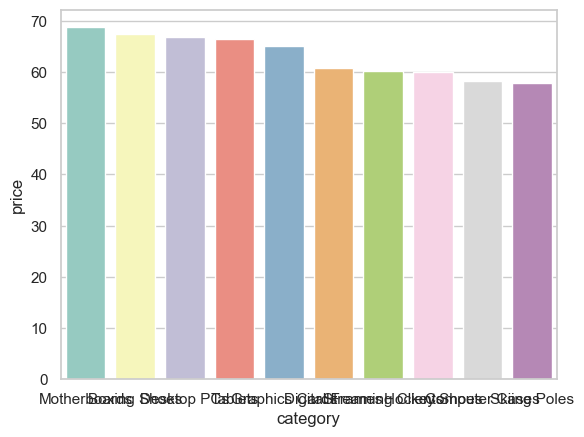

In [90]:
#Comparing average price for the top 10 categories 
average_price_top_10_categories = df_no_outliers.groupby(['category'])['price'].mean().sort_values(ascending=False).head(10)
# Plotting a bar chart 
sns.barplot(x=average_price_top_10_categories.index, y=average_price_top_10_categories, palette="Set3");

3. Box Plots:

Visualize the distribution of product ratings based on their category using side-by-side box plots. Filter out the top 10 categories based on count for better visualization.


<Axes: xlabel='category', ylabel='stars'>

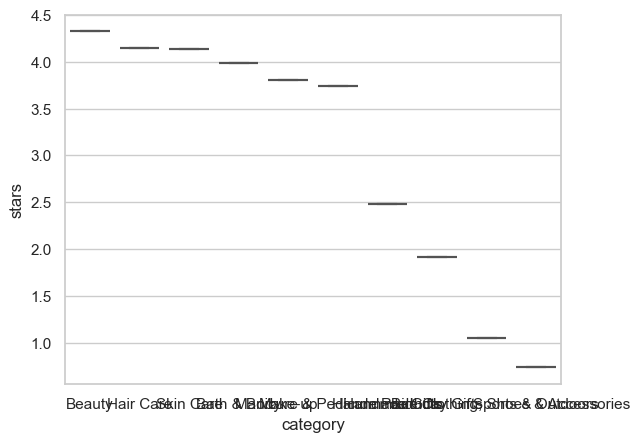

In [110]:

# Filter out the top 10 categories based on count for better visualization.
category_10_counts_sorted = df_no_outliers['category'].value_counts().sort_values(ascending=False).head(10)
list_categories_top_10 = category_10_counts_sorted.index.tolist()
# Filter out the list of values from the column
filtered_df = df[df['category'].isin(list_categories_top_10)]
product_rating_top_10_categories = filtered_df.groupby(['category'])['stars'].mean().sort_values(ascending=False)
# Convert the list of tuples to a DataFrame
df_product_rating_top_10_categories = pd.DataFrame(product_rating_top_10_categories).reset_index()

sns.boxplot(data=df_product_rating_top_10_categories, x='category', y='stars', palette="coolwarm")



Which category tends to receive the highest median rating from customers? Don't filter here by top categories.

Part 3: Investigating the Interplay Between Product Prices and Ratings
Objective: Analyze how product ratings (stars) correlate with product prices.

1. Correlation Coefficients:

Calculate the correlation coefficient between price and stars.

In [111]:
# Calculating the Pearson correlation coefficient between 'SalePrice' and 'GrLivArea' columns
correlation = filtered_df['price'].corr(filtered_df['stars'])
correlation

-0.10234386878714892

Is there a significant correlation between product price and its rating?

A correlation of -0.10234386878714892 indicates a weak negative linear relationship between the two variables being compared

2. Visualizations:

Use a scatter plot to visualize the relationship between product rating and price.

<Axes: xlabel='stars', ylabel='price'>

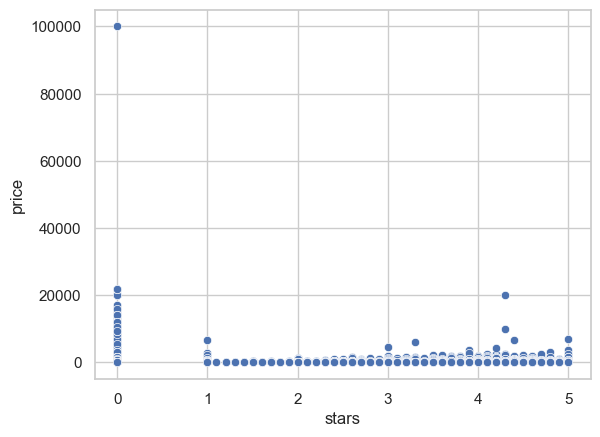

In [139]:
sns.scatterplot(data=filtered_df, x='stars', y='price')

What patterns can you observe?

Rating is not relate to prices 

Use a correlation heatmap to visualize correlations between all numerical variables.

In [144]:
# Separating between discrete and continuous variables, as discrete ones could potentially be treated as categorical.
# Remember to adjust the threshold (in this case, < 20) based on your dataset's specific characteristics and domain knowledge.
potential_categorical_from_numerical = df.select_dtypes("number")


In [ ]:
potential_categorical_from_numerical['stars'] = potential_categorical_from_numerical['stars'].astype(int)
potential_categorical_from_numerical['price'] = potential_categorical_from_numerical['price'].astype(int)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2443651 entries, 0 to 2443650
Data columns (total 4 columns):
 #   Column             Dtype
---  ------             -----
 0   stars              int32
 1   reviews            int64
 2   price              int32
 3   boughtInLastMonth  int64
dtypes: int32(2), int64(2)
memory usage: 55.9 MB


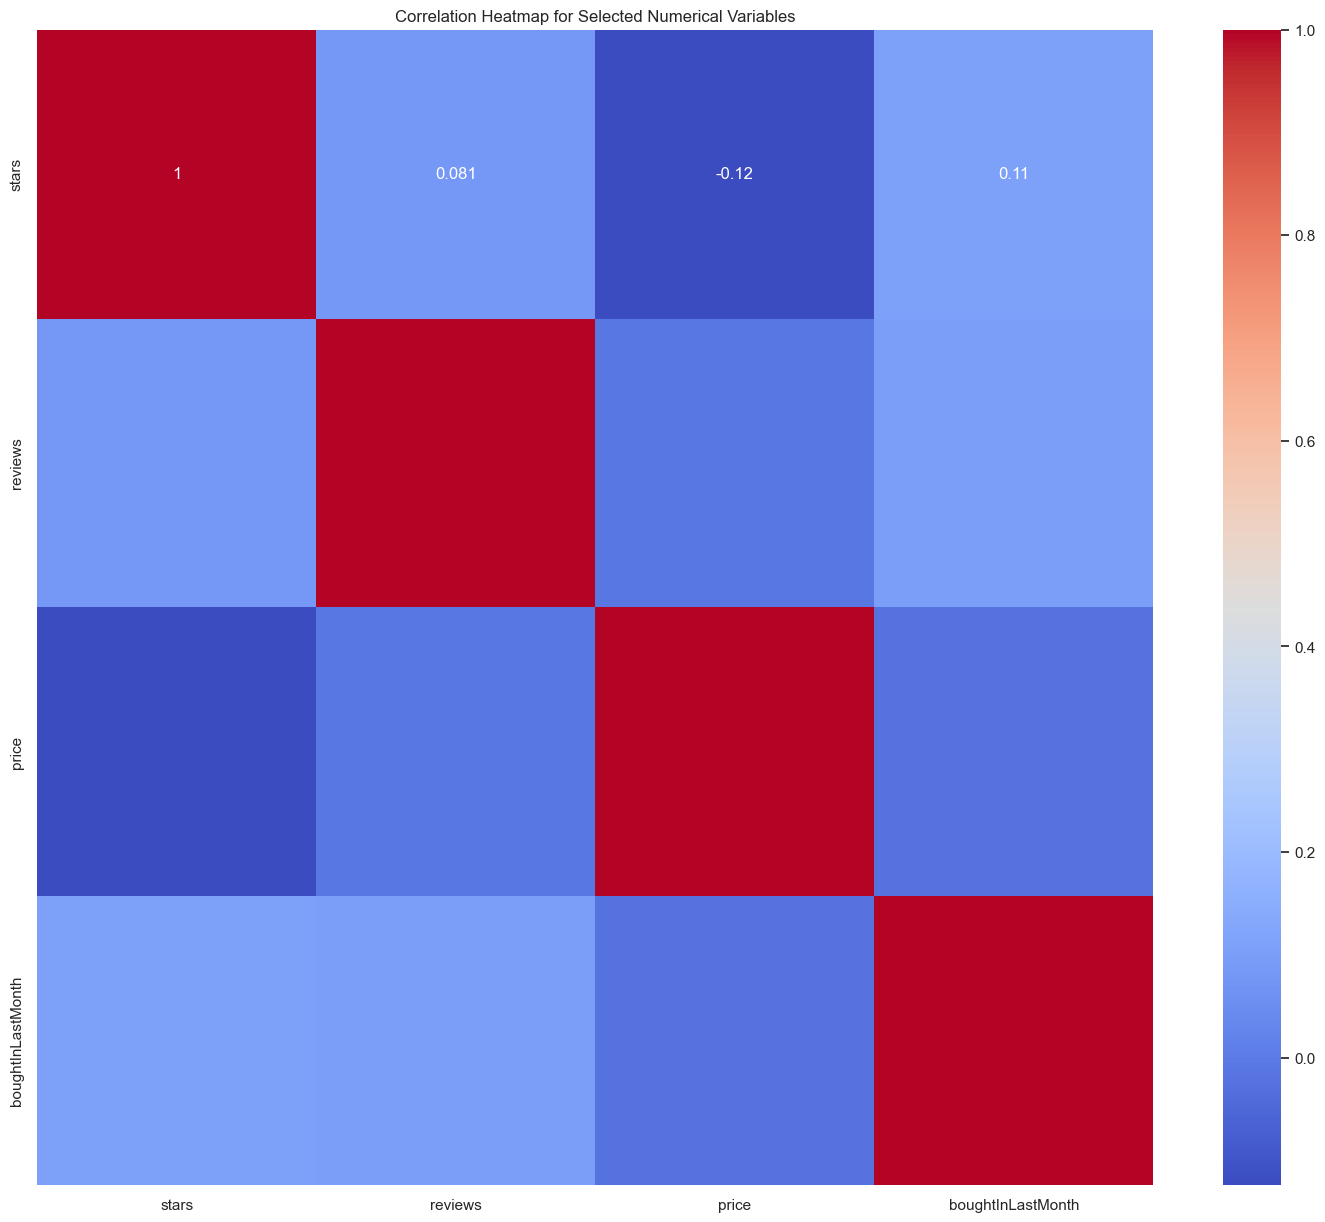

In [151]:
correlation_matrix = potential_categorical_from_numerical.corr()

# Setting up the matplotlib figure with an appropriate size
plt.figure(figsize=(18, 15))

# Drawing the heatmap for the numerical columns
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")

plt.title("Correlation Heatmap for Selected Numerical Variables")
plt.show()

Examine if product prices typically follow a normal distribution using a QQ plot.

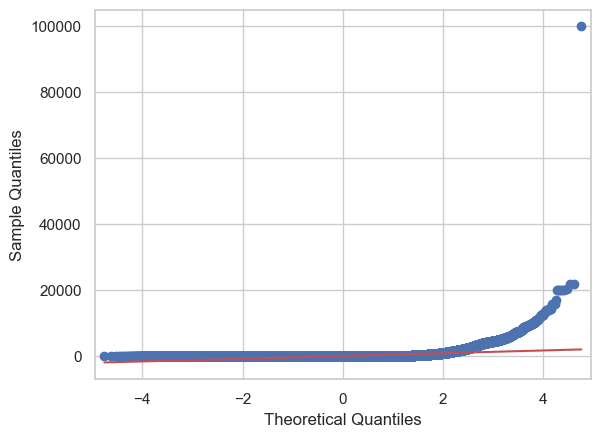

In [116]:
import statsmodels.api as sm

# Generating a Q-Q plot for 'price' to check if its distribution follows a normal distribution
sm.qqplot(filtered_df['price'], line='s');

Submission: Submit a Jupyter Notebook which contains code and a business-centric report summarizing your findings.

Bonus:

Do the same analysis without taking out the outliers. What are your insights?